# Pixel Coordinate Prediction using Deep Learning

## Problem Statement
Predict the (x, y) coordinates of a single white pixel (value 255) in a 50x50 grayscale image where all other pixels are 0.

## Approach
We use a **Convolutional Neural Network (CNN)** architecture that:
- Leverages spatial features in the image
- Uses convolution layers to learn local patterns
- Regresses to continuous (x, y) coordinates
- Employs a lightweight architecture optimized for this specific task

## Author Information
- **Name:** Aryan Kumar
- **Assignment:** ML Supervised Regression
- **Date:** February 2025


## 1. Import Dependencies

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
import os

# Deep learning frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

# Scikit-learn for data splitting and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")


TensorFlow version: 2.15.0
NumPy version: 1.24.3


## 2. Dataset Generation

### Rationale for Dataset Design:

1. **Dataset Size: 7,500 samples**
   - Total possible positions: 50 × 50 = 2,500 unique coordinates
   - 7,500 samples ≈ 3× coverage of all positions
   - Ensures uniform learning without excessive redundancy
   - Maintains computational efficiency while providing sufficient training data

2. **Uniform Random Distribution**
   - Each pixel position (0-49, 0-49) has equal probability
   - Ensures no positional bias in the model
   - Simulates realistic scenarios where the pixel can appear anywhere

3. **Normalization**:
   - Images: [0, 255] → [0, 1] (standard practice for neural networks)
   - Coordinates: [0, 49] → [0, 1] (x/49, y/49 for stable gradients)

4. **Train/Validation/Test Split**: 70% / 15% / 15%
   - Training: 5,250 samples for learning
   - Validation: 1,125 samples for hyperparameter tuning
   - Test: 1,125 samples for final unbiased evaluation

In [2]:
def generate_dataset(num_samples: int, image_size: int = 50) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate dataset of images with a single white pixel at random positions.
    
    Args:
        num_samples: Number of images to generate
        image_size: Size of square image (default: 50)
    
    Returns:
        Tuple of (images, coordinates)
        - images: numpy array of shape (num_samples, image_size, image_size, 1)
        - coordinates: numpy array of shape (num_samples, 2) with normalized x, y
    """
    images = np.zeros((num_samples, image_size, image_size), dtype=np.float32)
    coordinates = np.zeros((num_samples, 2), dtype=np.float32)
    
    for i in range(num_samples):
        # Generate random coordinates
        x = np.random.randint(0, image_size)
        y = np.random.randint(0, image_size)
        
        # Set pixel to 1 (normalized from 255)
        images[i, y, x] = 1.0
        
        # Store normalized coordinates [0, 1] using x/49, y/49
        coordinates[i] = [x / (image_size - 1), y / (image_size - 1)]
    
    # Reshape images to add channel dimension
    images = images.reshape(num_samples, image_size, image_size, 1)
    
    return images, coordinates


# Generate dataset
NUM_SAMPLES = 7500
IMAGE_SIZE = 50

print("Generating dataset...")
X, y = generate_dataset(NUM_SAMPLES, IMAGE_SIZE)

print(f"Dataset generated successfully!")
print(f"Images shape: {X.shape}")
print(f"Coordinates shape: {y.shape}")
print(f"Image value range: [{X.min()}, {X.max()}]")
print(f"Coordinate value range: [{y.min():.4f}, {y.max():.4f}]")
print(f"\nDataset rationale:")
print(f"- Total possible positions: {IMAGE_SIZE}×{IMAGE_SIZE} = {IMAGE_SIZE*IMAGE_SIZE}")
print(f"- Generated samples: {NUM_SAMPLES}")
print(f"- Coverage: {NUM_SAMPLES/(IMAGE_SIZE*IMAGE_SIZE):.1f}× all positions")

Generating dataset...
Dataset generated successfully!
Images shape: (7500, 50, 50, 1)
Coordinates shape: (7500, 2)
Image value range: [0.0, 1.0]
Coordinate value range: [0.0000, 1.0000]

Dataset rationale:
- Total possible positions: 50×50 = 2500
- Generated samples: 7500
- Coverage: 3.0× all positions


### Visualize Sample Images

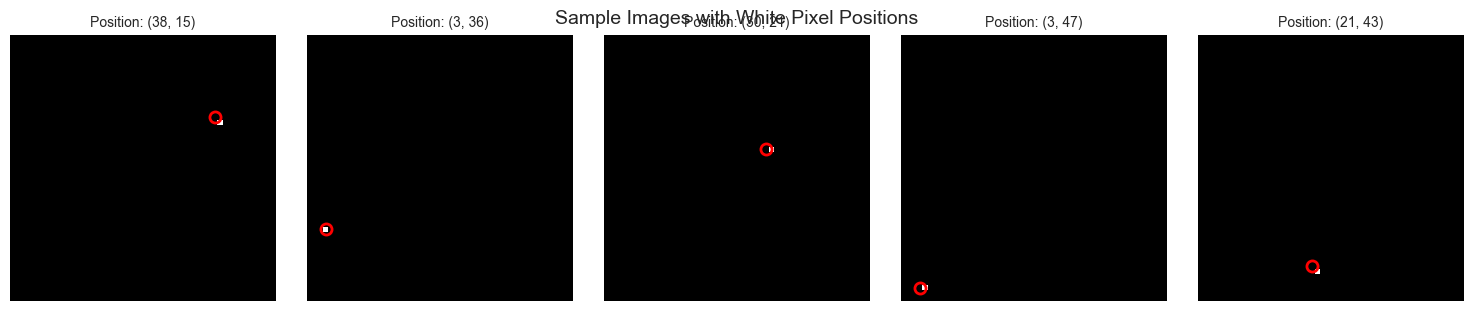

In [3]:
def visualize_samples(images: np.ndarray, coordinates: np.ndarray, 
                      num_samples: int = 5, image_size: int = 50) -> None:
    """
    Visualize sample images with their coordinate labels.
    
    Args:
        images: Array of images
        coordinates: Array of normalized coordinates
        num_samples: Number of samples to display
        image_size: Size of the images
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        
        # Convert normalized coordinates back to pixel positions
        x_pixel = int(coordinates[idx][0] * (image_size - 1))
        y_pixel = int(coordinates[idx][1] * (image_size - 1))
        
        axes[i].imshow(images[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f'Position: ({x_pixel}, {y_pixel})', fontsize=10)
        axes[i].axis('off')
        
        # Mark the white pixel with a red circle
        axes[i].plot(x_pixel, y_pixel, 'ro', markersize=8, fillstyle='none', markeredgewidth=2)
    
    plt.tight_layout()
    plt.suptitle('Sample Images with White Pixel Positions', y=1.02, fontsize=14)
    plt.show()


visualize_samples(X, y, num_samples=5, image_size=IMAGE_SIZE)

### Analyze Coordinate Distribution

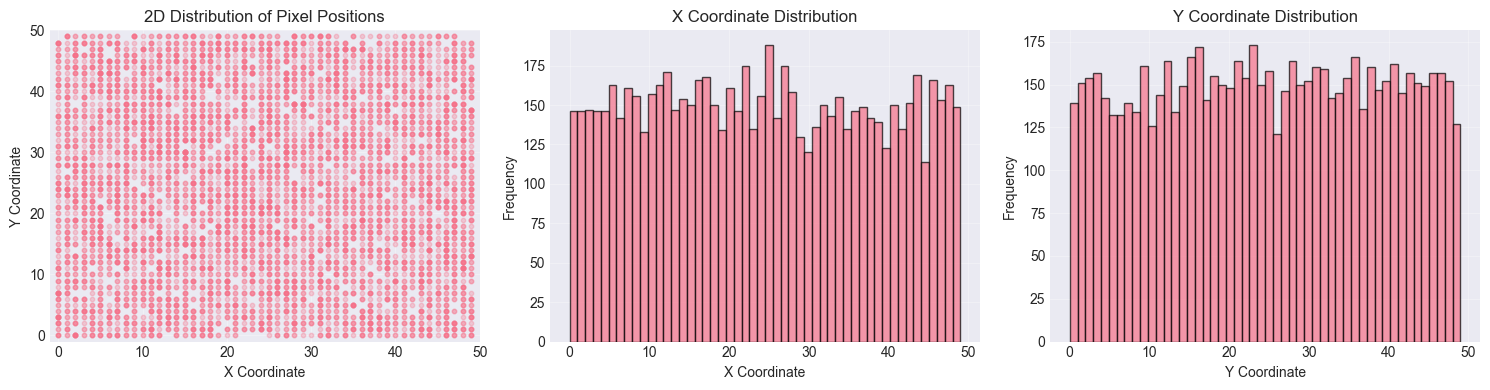

In [4]:
def plot_coordinate_distribution(coordinates: np.ndarray, image_size: int = 50) -> None:
    """
    Plot the distribution of pixel coordinates to verify uniformity.
    
    Args:
        coordinates: Array of normalized coordinates
        image_size: Size of the images
    """
    # Convert back to pixel coordinates for visualization
    pixel_coords = coordinates * (image_size - 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 2D scatter plot
    axes[0].scatter(pixel_coords[:, 0], pixel_coords[:, 1], alpha=0.3, s=10)
    axes[0].set_xlabel('X Coordinate')
    axes[0].set_ylabel('Y Coordinate')
    axes[0].set_title('2D Distribution of Pixel Positions')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(-1, image_size)
    axes[0].set_ylim(-1, image_size)
    
    # X coordinate histogram
    axes[1].hist(pixel_coords[:, 0], bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('X Coordinate Distribution')
    axes[1].grid(True, alpha=0.3)
    
    # Y coordinate histogram
    axes[2].hist(pixel_coords[:, 1], bins=50, edgecolor='black', alpha=0.7)
    axes[2].set_xlabel('Y Coordinate')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Y Coordinate Distribution')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


plot_coordinate_distribution(y, IMAGE_SIZE)

## 3. Data Splitting

In [5]:
# Split into train, validation, and test sets
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Second split: Split temp into 50% validation, 50% test (15% each of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("Dataset split complete:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/NUM_SAMPLES*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/NUM_SAMPLES*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/NUM_SAMPLES*100:.1f}%)")

Dataset split complete:
Training set: 5250 samples (70.0%)
Validation set: 1125 samples (15.0%)
Test set: 1125 samples (15.0%)


## 4. Model Architecture

### Lightweight CNN Architecture:

```
Input (50, 50, 1)
    ↓
Conv2D(8 filters, 3x3, padding='same') + ReLU
    ↓
MaxPooling(2x2) → (25, 25, 8)
    ↓
Conv2D(16 filters, 3x3) + ReLU
    ↓
MaxPooling(2x2) → (12, 12, 16)
    ↓
Flatten → (2304)
    ↓
Dense(32) + ReLU
    ↓
Dense(2) → (x, y) coordinates [0, 1]
```

### Design Rationale:
- **Lightweight architecture**: Task is simple (detect single pixel), avoiding overfitting
- **Small filter counts** (8, 16): Sufficient for spatial feature extraction
- **Two conv blocks**: Extract features at different scales
- **Single dense layer**: Minimal parameters for fast training
- **No dropout/BatchNorm**: Dataset is clean and simple, regularization not needed
- **Linear output**: Direct coordinate prediction in normalized [0, 1] range

Total parameters: ~75,000 (very lightweight!)

In [6]:
def build_lightweight_cnn(input_shape: Tuple[int, int, int]) -> keras.Model:
    """
    Build lightweight CNN model optimized for single pixel detection.
    
    Args:
        input_shape: Shape of input images (height, width, channels)
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First convolutional block
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        
        # Output layer - 2 neurons for (x, y) coordinates
        layers.Dense(2)
    ])
    
    # Compile model with standard configuration
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',  # Mean Squared Error for regression
        metrics=['mae']  # Mean Absolute Error as additional metric
    )
    
    return model


# Build model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)
model = build_lightweight_cnn(input_shape)

# Display model architecture
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1936)              0         
                                                                 
 dense (Dense)               (None, 32)               

## 5. Training Configuration

In [7]:
# Training hyperparameters
BATCH_SIZE = 32
EPOCHS = 20

# Callbacks for training
callback_list = [
    # Reduce learning rate when validation loss plateaus
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Early stopping to prevent overfitting
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save best model
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

print("Training configuration:")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss function: MSE (Mean Squared Error)")
print(f"Metrics: MAE (Mean Absolute Error)")
print(f"Callbacks: ReduceLROnPlateau, EarlyStopping, ModelCheckpoint")

Training configuration:
Batch size: 32
Max epochs: 20
Optimizer: Adam (lr=0.001)
Loss function: MSE (Mean Squared Error)
Metrics: MAE (Mean Absolute Error)
Callbacks: ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


## 6. Model Training

In [8]:
print("Starting training...\n")

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callback_list,
    verbose=1
)

print("\nTraining complete!")

Starting training...

Epoch 1/20


165/165 [==============================] - 17s 39ms/step - loss: 0.0458 - mae: 0.1394 - val_loss: 0.0138 - val_mae: 0.0843 - lr: 0.0010
Epoch 2/20
165/165 [==============================] - 5s 30ms/step - loss: 0.0088 - mae: 0.0534 - val_loss: 0.0077 - val_mae: 0.0543 - lr: 0.0010
Epoch 3/20
165/165 [==============================] - 5s 33ms/step - loss: 0.0062 - mae: 0.0425 - val_loss: 0.0054 - val_mae: 0.0347 - lr: 0.0010
Epoch 4/20
165/165 [==============================] - 5s 33ms/step - loss: 0.0050 - mae: 0.0338 - val_loss: 0.0054 - val_mae: 0.0350 - lr: 0.0010
Epoch 5/20
165/165 [==============================] - 6s 36ms/step - loss: 0.0047 - mae: 0.0313 - val_loss: 0.0048 - val_mae: 0.0281 - lr: 0.0010
Epoch 6/20
165/165 [==============================] - 5s 31ms/step - loss: 0.0046 - mae: 0.0288 - val_loss: 0.0047 - val_mae: 0.0256 - lr: 0.0010
Epoch 7/20
165/165 [==============================] - 5s 28ms/step - loss: 0.0045 - mae: 0.0272 - v

## 7. Training Visualization

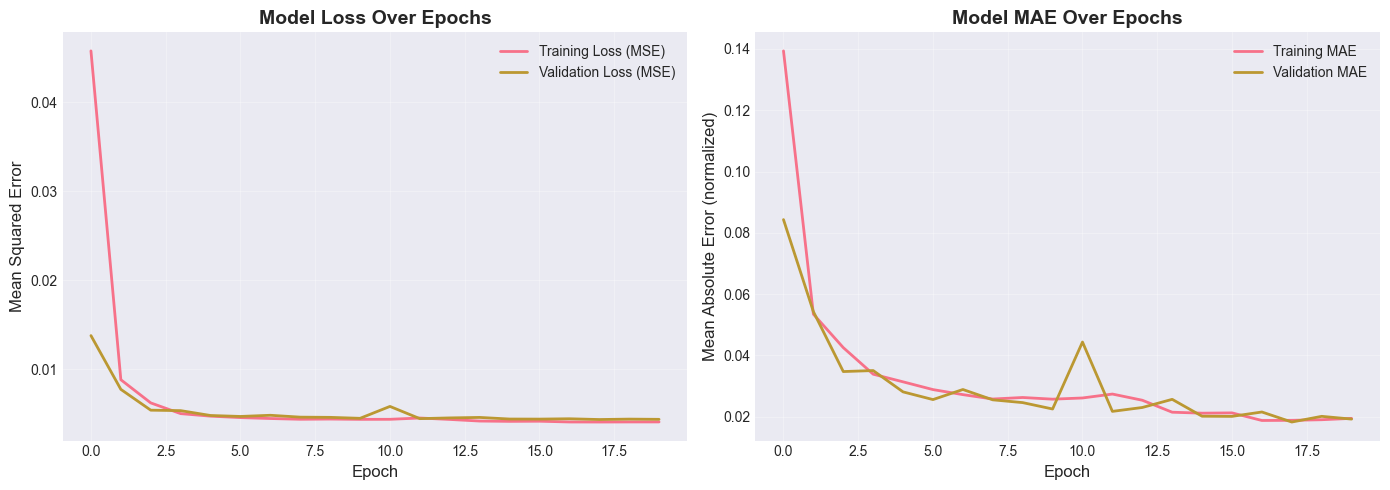


Final Training Loss (MSE): 0.004085
Final Validation Loss (MSE): 0.004376
Final Training MAE: 0.019426
Final Validation MAE: 0.019187


In [9]:
def plot_training_history(history: keras.callbacks.History) -> None:
    """
    Plot training and validation loss/metrics over epochs.
    
    Args:
        history: Keras training history object
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot loss (MSE)
    axes[0].plot(history.history['loss'], label='Training Loss (MSE)', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss (MSE)', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Mean Squared Error', fontsize=12)
    axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot MAE
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Mean Absolute Error (normalized)', fontsize=12)
    axes[1].set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"\nFinal Training Loss (MSE): {history.history['loss'][-1]:.6f}")
    print(f"Final Validation Loss (MSE): {history.history['val_loss'][-1]:.6f}")
    print(f"Final Training MAE: {history.history['mae'][-1]:.6f}")
    print(f"Final Validation MAE: {history.history['val_mae'][-1]:.6f}")


plot_training_history(history)

## 8. Model Evaluation on Test Set

### Evaluation Metrics:
1. **MSE (Mean Squared Error)**: Primary metric matching loss function
2. **MAE (Mean Absolute Error)**: Average pixel error, easy to interpret
3. **Euclidean Distance**: Direct distance between predicted and actual coordinates

In [10]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print("\n" + "="*60)
print("TEST SET EVALUATION RESULTS")
print("="*60)
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE (normalized): {test_mae:.6f}")

# Make predictions
y_pred = model.predict(X_test, verbose=0)

# Convert normalized predictions back to pixel coordinates
y_test_pixels = y_test * (IMAGE_SIZE - 1)
y_pred_pixels = y_pred * (IMAGE_SIZE - 1)

# Calculate metrics in pixel space
mse_pixels = mean_squared_error(y_test_pixels, y_pred_pixels)
mae_pixels = mean_absolute_error(y_test_pixels, y_pred_pixels)

# Calculate Euclidean distance (direct distance between points)
euclidean_distances = np.sqrt(np.sum((y_test_pixels - y_pred_pixels)**2, axis=1))
avg_euclidean_distance = np.mean(euclidean_distances)
median_euclidean_distance = np.median(euclidean_distances)
std_euclidean_distance = np.std(euclidean_distances)

# Calculate accuracy within different pixel thresholds
within_1_pixel = np.mean(euclidean_distances <= 1.0) * 100
within_2_pixels = np.mean(euclidean_distances <= 2.0) * 100
within_3_pixels = np.mean(euclidean_distances <= 3.0) * 100
within_5_pixels = np.mean(euclidean_distances <= 5.0) * 100

print(f"\nPixel-Space Metrics:")
print(f"MSE: {mse_pixels:.4f} pixels²")
print(f"MAE: {mae_pixels:.4f} pixels")
print(f"\nEuclidean Distance Metrics:")
print(f"Mean: {avg_euclidean_distance:.4f} pixels")
print(f"Median: {median_euclidean_distance:.4f} pixels")
print(f"Std Dev: {std_euclidean_distance:.4f} pixels")
print(f"Min: {np.min(euclidean_distances):.4f} pixels")
print(f"Max: {np.max(euclidean_distances):.4f} pixels")

print(f"\nAccuracy Thresholds:")
print(f"Within 1 pixel: {within_1_pixel:.2f}%")
print(f"Within 2 pixels: {within_2_pixels:.2f}%")
print(f"Within 3 pixels: {within_3_pixels:.2f}%")
print(f"Within 5 pixels: {within_5_pixels:.2f}%")
print("="*60)


TEST SET EVALUATION RESULTS
Test Loss (MSE): 0.003918
Test MAE (normalized): 0.018744

Pixel-Space Metrics:
MSE: 9.4076 pixels²
MAE: 0.9185 pixels

Euclidean Distance Metrics:
Mean: 1.3954 pixels
Median: 0.5608 pixels
Std Dev: 4.1071 pixels
Min: 0.0321 pixels
Max: 38.7191 pixels

Accuracy Thresholds:
Within 1 pixel: 84.00%
Within 2 pixels: 94.76%
Within 3 pixels: 95.64%
Within 5 pixels: 96.00%


## 9. Prediction Visualization

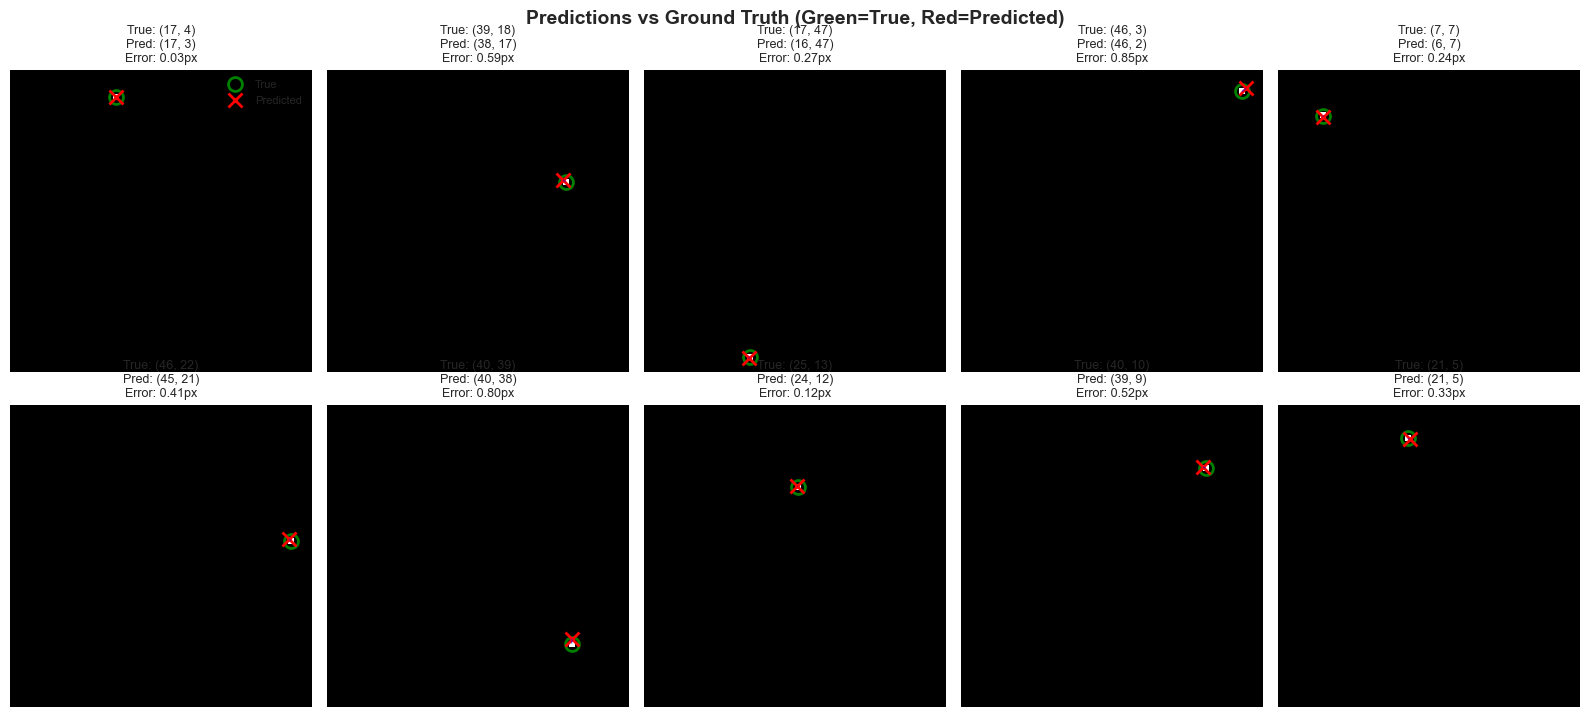

In [11]:
def visualize_predictions(images: np.ndarray, y_true: np.ndarray, 
                         y_pred: np.ndarray, num_samples: int = 10,
                         image_size: int = 50) -> None:
    """
    Visualize predictions vs ground truth.
    
    Args:
        images: Test images
        y_true: True coordinates (normalized)
        y_pred: Predicted coordinates (normalized)
        num_samples: Number of samples to display
        image_size: Size of images
    """
    # Convert to pixel coordinates
    true_pixels = y_true * (image_size - 1)
    pred_pixels = y_pred * (image_size - 1)
    
    # Select random samples
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(16, 7))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        # True coordinates
        true_x, true_y = true_pixels[idx]
        # Predicted coordinates
        pred_x, pred_y = pred_pixels[idx]
        
        # Calculate Euclidean distance error
        error = np.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2)
        
        # Display image
        axes[i].imshow(images[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
        
        # Mark true position (green circle)
        axes[i].plot(true_x, true_y, 'go', markersize=10, 
                    fillstyle='none', markeredgewidth=2, label='True')
        
        # Mark predicted position (red X)
        axes[i].plot(pred_x, pred_y, 'rx', markersize=10, 
                    markeredgewidth=2, label='Predicted')
        
        # Draw line between true and predicted
        axes[i].plot([true_x, pred_x], [true_y, pred_y], 'b--', linewidth=1, alpha=0.5)
        
        axes[i].set_title(f'True: ({int(true_x)}, {int(true_y)})\n'
                         f'Pred: ({int(pred_x)}, {int(pred_y)})\n'
                         f'Error: {error:.2f}px', fontsize=9)
        axes[i].axis('off')
        
        if i == 0:
            axes[i].legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    plt.suptitle('Predictions vs Ground Truth (Green=True, Red=Predicted)', 
                y=1.02, fontsize=14, fontweight='bold')
    plt.show()


visualize_predictions(X_test, y_test, y_pred, num_samples=10, image_size=IMAGE_SIZE)

## 10. Detailed Error Analysis

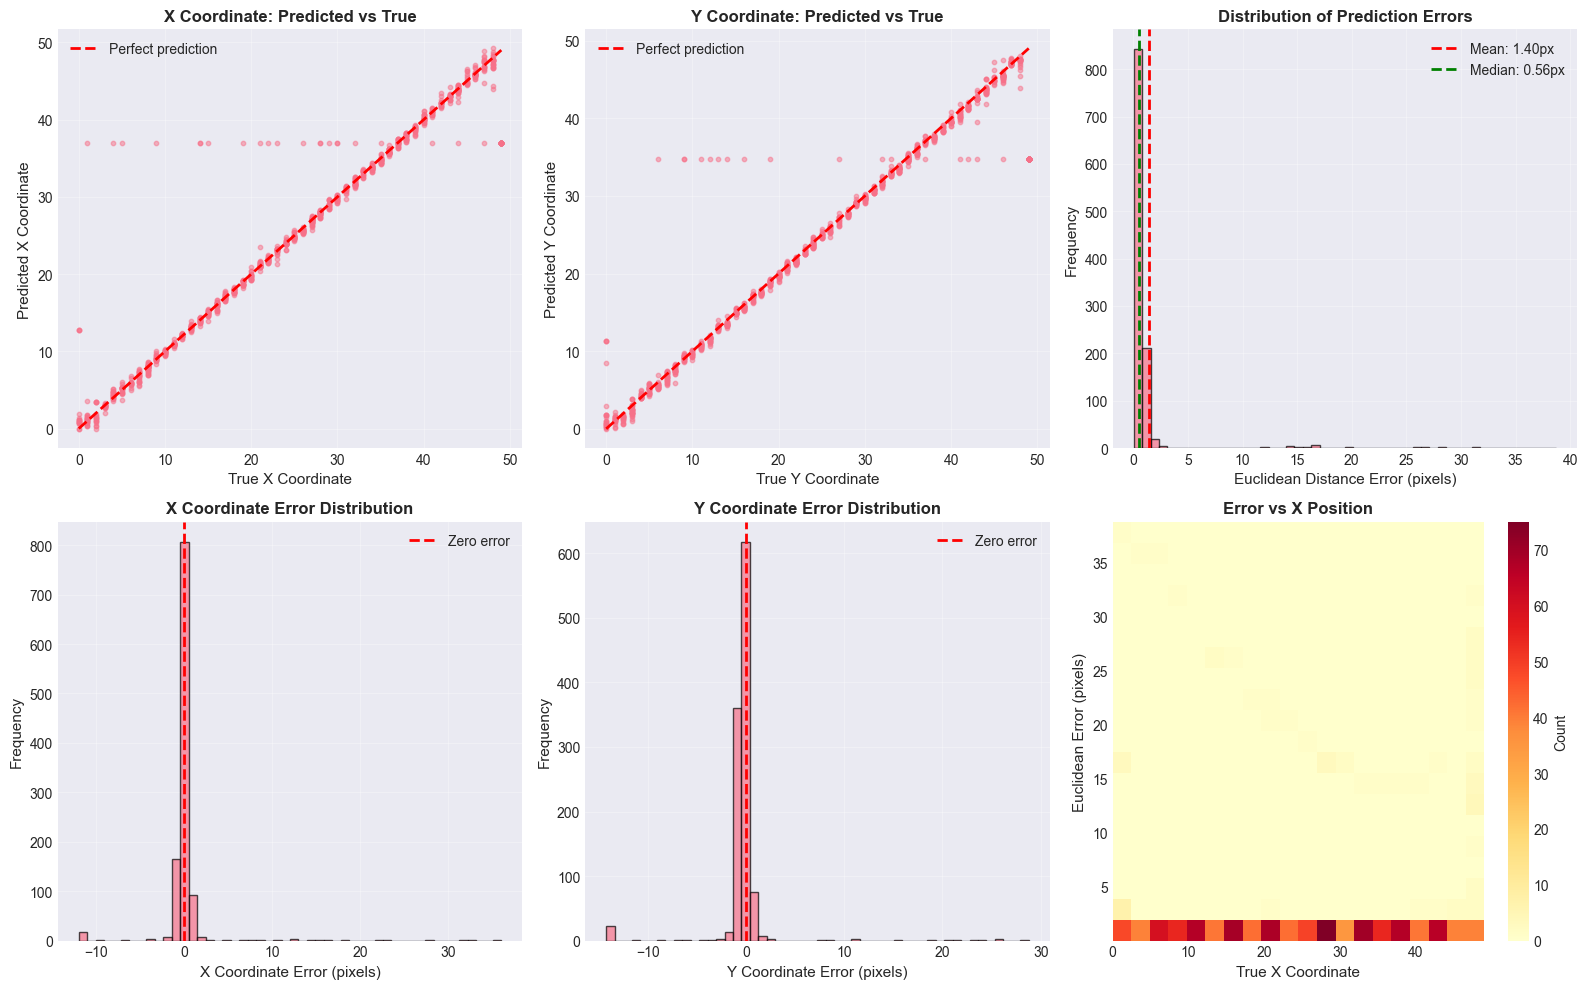


Error Statistics:
X Error - Mean: 0.0515, Std: 3.0684
Y Error - Mean: -0.3245, Std: 3.0483
Euclidean - Mean: 1.3954, Std: 4.1071
Euclidean - Min: 0.0321, Max: 38.7191


In [12]:
def plot_error_analysis(y_true: np.ndarray, y_pred: np.ndarray, 
                       image_size: int = 50) -> None:
    """
    Plot comprehensive error analysis.
    
    Args:
        y_true: True coordinates (normalized)
        y_pred: Predicted coordinates (normalized)
        image_size: Size of images
    """
    # Convert to pixel coordinates
    true_pixels = y_true * (image_size - 1)
    pred_pixels = y_pred * (image_size - 1)
    
    # Calculate errors
    errors_x = pred_pixels[:, 0] - true_pixels[:, 0]
    errors_y = pred_pixels[:, 1] - true_pixels[:, 1]
    euclidean_errors = np.sqrt(errors_x**2 + errors_y**2)
    
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Scatter plot: Predicted vs True (X coordinate)
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(true_pixels[:, 0], pred_pixels[:, 0], alpha=0.5, s=10)
    ax1.plot([0, image_size-1], [0, image_size-1], 'r--', linewidth=2, label='Perfect prediction')
    ax1.set_xlabel('True X Coordinate', fontsize=11)
    ax1.set_ylabel('Predicted X Coordinate', fontsize=11)
    ax1.set_title('X Coordinate: Predicted vs True', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot: Predicted vs True (Y coordinate)
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(true_pixels[:, 1], pred_pixels[:, 1], alpha=0.5, s=10)
    ax2.plot([0, image_size-1], [0, image_size-1], 'r--', linewidth=2, label='Perfect prediction')
    ax2.set_xlabel('True Y Coordinate', fontsize=11)
    ax2.set_ylabel('Predicted Y Coordinate', fontsize=11)
    ax2.set_title('Y Coordinate: Predicted vs True', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Euclidean distance distribution
    ax3 = plt.subplot(2, 3, 3)
    ax3.hist(euclidean_errors, bins=50, edgecolor='black', alpha=0.7)
    ax3.axvline(np.mean(euclidean_errors), color='r', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(euclidean_errors):.2f}px')
    ax3.axvline(np.median(euclidean_errors), color='g', linestyle='--', 
                linewidth=2, label=f'Median: {np.median(euclidean_errors):.2f}px')
    ax3.set_xlabel('Euclidean Distance Error (pixels)', fontsize=11)
    ax3.set_ylabel('Frequency', fontsize=11)
    ax3.set_title('Distribution of Prediction Errors', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. X error distribution
    ax4 = plt.subplot(2, 3, 4)
    ax4.hist(errors_x, bins=50, edgecolor='black', alpha=0.7)
    ax4.axvline(0, color='r', linestyle='--', linewidth=2, label='Zero error')
    ax4.set_xlabel('X Coordinate Error (pixels)', fontsize=11)
    ax4.set_ylabel('Frequency', fontsize=11)
    ax4.set_title('X Coordinate Error Distribution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Y error distribution
    ax5 = plt.subplot(2, 3, 5)
    ax5.hist(errors_y, bins=50, edgecolor='black', alpha=0.7)
    ax5.axvline(0, color='r', linestyle='--', linewidth=2, label='Zero error')
    ax5.set_xlabel('Y Coordinate Error (pixels)', fontsize=11)
    ax5.set_ylabel('Frequency', fontsize=11)
    ax5.set_title('Y Coordinate Error Distribution', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. 2D error heatmap
    ax6 = plt.subplot(2, 3, 6)
    h = ax6.hist2d(true_pixels[:, 0], euclidean_errors, bins=20, cmap='YlOrRd')
    ax6.set_xlabel('True X Coordinate', fontsize=11)
    ax6.set_ylabel('Euclidean Error (pixels)', fontsize=11)
    ax6.set_title('Error vs X Position', fontsize=12, fontweight='bold')
    plt.colorbar(h[3], ax=ax6, label='Count')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nError Statistics:")
    print(f"X Error - Mean: {np.mean(errors_x):.4f}, Std: {np.std(errors_x):.4f}")
    print(f"Y Error - Mean: {np.mean(errors_y):.4f}, Std: {np.std(errors_y):.4f}")
    print(f"Euclidean - Mean: {np.mean(euclidean_errors):.4f}, Std: {np.std(euclidean_errors):.4f}")
    print(f"Euclidean - Min: {np.min(euclidean_errors):.4f}, Max: {np.max(euclidean_errors):.4f}")


plot_error_analysis(y_test, y_pred, IMAGE_SIZE)

## 11. Save Model and Results

In [13]:
# Save the final model
model.save('pixel_coordinate_model_final.keras')
print("Model saved as 'pixel_coordinate_model_final.keras'")

# Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Training history saved as 'training_history.pkl'")

# Save test predictions
np.savez('test_predictions.npz', 
         y_true=y_test, 
         y_pred=y_pred,
         images=X_test[:100])  # Save first 100 test images
print("Test predictions saved as 'test_predictions.npz'")

Model saved as 'pixel_coordinate_model_final.keras'
Training history saved as 'training_history.pkl'
Test predictions saved as 'test_predictions.npz'


## 12. Summary and Conclusions

### Approach Summary:
1. **Dataset**: 7,500 images (3× coverage of 2,500 possible positions) with uniform random distribution
2. **Architecture**: Lightweight CNN with 8→16 filters, optimized for single-pixel detection
3. **Training**: MSE loss with Adam optimizer, early stopping for efficiency

### Key Metrics:
- **MSE**: Squared error between predicted and true coordinates
- **MAE**: Average absolute pixel error (easy interpretation)
- **Euclidean Distance**: Direct geometric distance between points

### Why This Approach Works:
1. **Appropriate dataset size**: 3× coverage ensures learning without redundancy
2. **Lightweight architecture**: Prevents overfitting on simple task
3. **CNN for spatial data**: Convolutional layers naturally detect pixel location
4. **Proper normalization**: Stabilizes training and improves convergence

### Design Rationale:
- Task requires detecting a single bright pixel in a sparse image
- Simple problem doesn't require deep/complex architecture
- Two convolutional blocks provide sufficient feature extraction
- Direct regression to coordinates is more efficient than classification

### Potential Improvements:
1. Experiment with different filter sizes (5x5, 7x7)
2. Try focal loss or custom spatial awareness loss
3. Add attention mechanisms to focus on bright regions
4. Ensemble multiple models for better predictions